# Aprendizaje Profundo
Daniel López Gala - UO281798

Se dispone del conjunto de datos NIPS4BPLUS, el cual contiene 674 ficheros de audio con una duración total de menos de una hora. En estos audios podemos encontrar grabaciones de aproximadamente 5 segundos con cantos de pájaros realizadas en 39 localizaciones diferentes repartidas por 7 regiones de Francia y España.

# Aprendizaje Profundo
Daniel López Gala - UO281798

Se dispone del conjunto de datos NIPS4BPLUS, el cual contiene 674 ficheros de audio con una duración total de menos de una hora. En estos audios podemos encontrar grabaciones de aproximadamente 5 segundos con cantos de pájaros realizadas en 39 localizaciones diferentes repartidas por 7 regiones de Francia y España.

In [1]:
#base_path = "/content/drive/MyDrive/DeepLearning/"
base_path = ""
DEBUG = True

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

import torchaudio
import torchaudio.transforms as T
from torchaudio.transforms import Resample
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.models as models

from sklearn.metrics import f1_score

#%pip install transformers
#%pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.7 MB/s eta 0:00:00


## Preprocesamiento y visualización

- Se define una función `visualize_intermediates` para crear imágenes de los pasos intermedios usados en el preprocesamiento de los audios.

- La clase `AudioPreprocessing` define los pasos para procesar la imagen. Se incluyen:
  - Resample (No usado)
  - STFT (Convertir a espectrograma)
  - Normalización
  - Median clipping
  - Conectar puntos cercanos mediante filtros
  - Closing
  - Dilation
  - Median blur
  - Eliminar residuos

In [4]:
def visualize_intermediates(intermediates, sample_rate=44100, hop_length=196):

    # Set default background color for figures to white
    plt.rcParams['figure.facecolor'] = 'white'

    for key, value in intermediates.items():
        if len(value.shape) == 2 and value.shape[1] > 2:  # This indicates a waveform
            plt.figure(figsize=(12, 4))

            # Calculate time axis in seconds for waveform
            time_axis_waveform = np.linspace(0, value.shape[1] / sample_rate, value.shape[1])

            plt.plot(time_axis_waveform, value[0].cpu().numpy())
            plt.xlabel("Time (seconds)")
            plt.title(f"{key}")
            plt.show()
            continue

        print(f"Processing {key} with shape {value.shape}")

        if value.dim() == 4 and value.shape[-1] == 2:
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Calculate time axis in seconds for magnitude
        time_axis_magnitude = np.linspace(0, magnitude.shape[1] * hop_length / sample_rate, magnitude.shape[1])

        # Plot magnitude with inverted grayscale colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray_r', aspect='auto', origin='lower', extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, magnitude.shape[0]])
        plt.xlabel("Time (seconds)")
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi, extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, phase.shape[0]])
            plt.xlabel("Time (seconds)")
            plt.title(f"{key} Phase")
            plt.colorbar()
            plt.show()


In [5]:
class AudioPreprocessing(nn.Module):
    def __init__(self, debug=DEBUG, sample_rate=16000, n_fft=1024, win_length=1024, hop_length=196, augment=False):
        super().__init__()
        self.debug = debug
        self.augment = augment
        self.sample_rate = sample_rate
        self.resampler = T.Resample(44100, sample_rate)
        self.spectrogram = T.MelSpectrogram(sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length, f_min=500, f_max=15000)

    def normalize(self, spectrogram):
        min_val = torch.min(spectrogram)
        return (spectrogram - min_val) / (torch.max(spectrogram) - min_val + 1e-5)

    def median_blurring(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        img = cv2.medianBlur(img.astype(np.float32), 5)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def binary_image_creation(self, spectrogram, threshold=1.5):
        freq_median = torch.median(spectrogram, dim=2, keepdim=True).values
        time_median = torch.median(spectrogram, dim=1, keepdim=True).values
        mask = (spectrogram > threshold * freq_median) & (spectrogram > threshold * time_median)
        return mask.float()

    def spot_removal(self, spectrogram, threshold=0.5):
        # Threshold the spectrogram to get a binary mask
        binary_mask = (spectrogram > threshold).float()

        # Convert to numpy for morphological operations
        binary_np = binary_mask.squeeze(0).cpu().numpy().astype(np.uint8)

        # Define a kernel for morphological operations (adjust size as needed)
        kernel = np.ones((3, 3), np.uint8)

        # Perform morphological opening to remove small noise
        cleaned_binary_np = cv2.morphologyEx(binary_np, cv2.MORPH_OPEN, kernel)

        # Convert back to tensor
        cleaned_binary_mask = torch.tensor(cleaned_binary_np, device=spectrogram.device).float().unsqueeze(0)

        # Multiply with original spectrogram to remove the noise
        denoised_spectrogram = spectrogram * cleaned_binary_mask

        return denoised_spectrogram

    def morph_closing(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def random_time_shift(self, waveform, max_shift_sec=0.2):
        """ Randomly shifts the waveform in the time domain """
        max_shift = int(max_shift_sec * self.sample_rate)
        shift = random.randint(-max_shift, max_shift)
        return torch.roll(waveform, shifts=shift, dims=-1)

    def random_pitch_shift(self, waveform, max_shift=2):
        """ Randomly shifts the pitch of the waveform """
        shift = random.uniform(-max_shift, max_shift)
        return T.FrequencyMasking(freq_mask_param=int(shift))(waveform)

    def random_volume_gain(self, waveform, min_gain=0.5, max_gain=1.5):
        """ Randomly changes the volume of the waveform """
        gain = random.uniform(min_gain, max_gain)
        return waveform * gain

    def random_noise_injection(self, waveform, noise_level=0.005):
        """ Adds random noise to the waveform """
        noise = torch.randn_like(waveform) * noise_level
        return waveform + noise

    def forward(self, waveform):
        intermediates = {}

        # Data augmentation
        if self.augment:
            waveform = self.random_time_shift(waveform)
            waveform = self.random_pitch_shift(waveform)
            waveform = self.random_volume_gain(waveform)
            # waveform = self.random_noise_injection(waveform)

        # Resampling to the target sample rate
        waveform = self.resampler(waveform)

        # Convert stereo to mono if necessary by averaging the channels
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        spectrogram = self.spectrogram(waveform)
        if self.debug: intermediates['original_spectrograms'] = spectrogram

        spectrogram = self.normalize(spectrogram)
        spectrogram = self.median_blurring(spectrogram)
        if self.debug: intermediates['spectrograms_after_median_blurring'] = spectrogram

        spectrogram = self.binary_image_creation(spectrogram)
        if self.debug: intermediates['binary_image'] = spectrogram

        spectrogram = self.spot_removal(spectrogram)
        if self.debug: intermediates['spectrograms_after_spot_removal'] = spectrogram

        spectrogram = self.morph_closing(spectrogram)
        if self.debug: intermediates['spectrograms_after_morph_closing'] = spectrogram

        if not self.debug:
            return spectrogram, {}

        return (spectrogram, intermediates)

## Carga de datos

Se leen los audios de forma individual. Cada audio es un objeto. `BirdSongDataset` define el método `__getitem__` para obtener cada instancia del dataset.

No se tiene en cuenta en qué momento del audio suena cada pájaro, tan sólo qué pájaros suenan en cada audio. El problema se plantea como **clasificación multietiqueta**.

El método `get_class_proportions` se utiliza para comprobar que los datasets *train* y *validation* contienen la misma proporción de clases, es decir, están estratíficados.

In [6]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info, transform=None):
        segments = []

        unique_filenames = df['filename'].unique()  # Only process each audio file once
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(math.ceil(waveform.shape[1] / sample_rate))  # Total segments in the audio

            # Calculate the unique labels for each segment
            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                labels_in_segment = df[(df['filename'] == unique_filename) &
                                       (df['end'] > start_time) &
                                       (df['start'] < end_time)]['class'].unique().tolist()
                segments.append({
                    'filename': unique_filename,
                    'segment_idx': idx,
                    'start': start_time,
                    'end': end_time,
                    'class': ",".join(labels_in_segment)
                })

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.class_info = class_info
        # Store the transform, but we will not apply it in __getitem__
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        waveform, sample_rate = torchaudio.load(audio_path)

        # Ensure waveform is mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample from 44100 Hz to 16000 Hz if necessary
        if sample_rate != 16000:
            resampler = Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Extract 1-second segment
        start_sample = int(row['start'] * 16000)  # Use the new sample rate here
        end_sample = int(row['end'] * 16000)      # Use the new sample rate here
        waveform = waveform[:, start_sample:end_sample]

        # Padding if needed
        if waveform.shape[1] < 16000:  # Use the new sample rate here
            num_padding = 16000 - waveform.shape[1]  # Use the new sample rate here
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        class_names = row['class'].split(",") if row['class'] else []
        target = torch.zeros(len(self.class_info))
        for class_name in class_names:
            target[self.class_info.index(class_name)] = 1.0

        return waveform, target

    def get_filename(self, idx):
        return self.segments.iloc[idx]['filename']

train_csv = pd.read_csv(f'{base_path}data/train.csv') # CSV with train audio filenames, and bird class names labels.
class_info_csv = pd.read_csv(f'{base_path}data/class_info.csv')
class_names = class_info_csv['class name'].tolist()

# Convert the labels to a binary matrix form
y = np.zeros((len(train_csv), len(class_names)))
for i, (_, row) in enumerate(train_csv.iterrows()):
    labels = row['class'].split(",")
    for label in labels:
        y[i, class_names.index(label)] = 1

X_train, y_train, X_val, y_val = iterative_train_test_split(np.array(train_csv), y, test_size=0.2)

train_df = pd.DataFrame(X_train, columns=train_csv.columns)
valid_df = pd.DataFrame(X_val, columns=train_csv.columns)

train_transform = nn.Sequential(
    AudioPreprocessing(augment=True)
)

valid_transform = nn.Sequential(
    AudioPreprocessing(augment=False)
)

train_dataset = BirdSongDataset(train_df, f'{base_path}data/train/', class_names, transform=train_transform)
valid_dataset = BirdSongDataset(valid_df, f'{base_path}data/train/', class_names, transform=valid_transform)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [7]:
def aggregate_predictions(predictions, segments_df):
    aggregated_predictions = {}
    for filename in segments_df['filename'].unique():
        aggregated_predictions[filename] = set()
        segments = segments_df[segments_df['filename'] == filename]
        for idx, row in segments.iterrows():
            aggregated_predictions[filename].update(predictions[idx])
    return aggregated_predictions


In [8]:
specific_audio_segments = train_dataset.segments[train_dataset.segments['filename'] == 'nips4b_train001.wav']
print(specific_audio_segments)

              filename  segment_idx  start  end                    class
0  nips4b_train001.wav            0      0    1              Sylcan_song
1  nips4b_train001.wav            1      1    2  Sylcan_song,Petpet_song
2  nips4b_train001.wav            2      2    3  Sylcan_song,Petpet_song
3  nips4b_train001.wav            3      3    4                         
4  nips4b_train001.wav            4      4    5              Petpet_song
5  nips4b_train001.wav            5      5    6              Petpet_song


In [9]:
segment_idx = 2
waveform, label = train_dataset[segment_idx]
print(f"Label: {label}")

# Convert tensor label back to class names to check
predicted_classes = [class_name for idx, class_name in enumerate(class_names) if label[idx] == 1.0]
print("Predicted Classes:", predicted_classes)

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Predicted Classes: ['Petpet_song', 'Sylcan_song']


In [10]:
# if DEBUG:
#     print(f"Number of elements: {len(valid_dataset)}")
#     sample, target = valid_dataset[90]
#     processed_sample, intermediates = sample

#     print(processed_sample.shape)
#     num_positive_labels = target.sum().item()
#     print(target)
#     print(f"Number of positive labels: {num_positive_labels}")

#     predicted_classes = [class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0]
#     print("Predicted Classes:", predicted_classes)

#     visualize_intermediates(intermediates)

In [11]:
# if DEBUG:
#     print(f"Number of elements: {len(train_dataset)}")
#     sample, target = train_dataset[30]
#     processed_sample, intermediates = sample

#     print(processed_sample.shape)
#     num_positive_labels = target.sum().item()
#     print(target)
#     print(f"Number of positive labels: {num_positive_labels}")

#     predicted_classes = [class_name for idx, class_name in enumerate(class_names) if target[idx] == 1.0]
#     print("Predicted Classes:", predicted_classes)
#     visualize_intermediates(intermediates)

**Calcular la longitud máxima de las formas de onda**

Se determina la longitud máxima entre todas las formas de onda para poder rellenar (padding) o truncar los audios posteriormente, garantizando que todos tengan la misma longitud.

La función `collate_fn` se utiliza para procesar y combinar un lote (batch) de muestras en el dataloader. Asegura que todas las formas de onda tengan la misma longitud (rellenando con ceros si es necesario) y devuelve las formas de onda junto con sus objetivos (etiquetas). Para esto, necesita la longitud máxima calculada anteriormente.

In [12]:
def collate_fn(batch):
    # Extract the waveform (or spectrogram) and ignore intermediates (the dict used to debug) if they exist
    waveforms_or_spectrograms = [wf[0] if isinstance(wf, tuple) else wf for wf, _ in batch]

    if isinstance(batch[0][1], str):
        # This handles the Test set scenario where targets might be filenames
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, filenames = zip(*batch)
        return waveforms_or_spectrograms, filenames

    elif isinstance(batch[0][1], dict):
        # This handles the scenario where DEBUG is False and intermediates dictionary is returned
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        return waveforms_or_spectrograms  # Note: Here we return only the waveforms as there are no target labels

    else:
        # This handles the Training or validation batch scenario
        waveforms_or_spectrograms = torch.stack(waveforms_or_spectrograms)
        _, targets = zip(*batch)
        targets = torch.stack(targets)
        return waveforms_or_spectrograms, targets

BATCH_SIZE=6
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


## Definición del modelo

- Se define una arquitectura basada en el modelo ResNet50 preentrenado.
- Se adapta la primera capa convolucional para aceptar imágenes de un solo canal (grises).
- Se elimina la última capa completamente conectada del ResNet y se agrega una clasificación personalizada para adaptar la arquitectura al problema multietiqueta.

Una de las cosas que se ha probado, es utilizar una mezcla de *transfer-learning* y *fine-tuning*.

**Transferencia de aprendizaje**:

El modelo se carga y se adaptan algunas capas. Se congelan los pesos de las capas del modelo preentrenado para que no se actualicen durante el entrenamiento inicial, por lo que sólo las capas personalizadas, como la capa de clasificación, se entrenarán. Es decir, se adapta a una tarea diferente el modelo, manteniendo los pesos originales.

**Fine-tuning**:

Después de algunas épocas de entrenamiento determinadas en el código se desbloquean las capas del modelo preentrenado para que sus pesos también puedan actualizarse durante el entrenamiento

```python
if epoch == X:
    for param in model.features.parameters():
        param.requires_grad = True
```

Este fine-tuning ajusta el modelo a los datos específicos para mejorar el rendimiento, aunque causa cierto *overfitting* al sobreescribir los pesos originales con los datos de entrenamiento.

Finalmente, tan sólo se utiliza fine-tuning. Los resultados no cambiaban excesivamente.

## Entrenamiento

- Se utiliza BCE (Binary Cross Entropy), adecuada para problemas de clasificación multietiqueta junto a un optimizador Adam con tasa de aprendizaje `0.0001`.
- Se utiliza un programador de learning rate ReduceLROnPlateau, o CosineAnnealingLR, que disminuye la tasa de aprendizaje si la función de pérdida no mejora.

El proceso de entrenamiento se ejecuta a través de 20-50 épocas, y durante cada época se calcula la pérdida en entrenamiento y se ajustan los pesos del modelo, se calcula el F1 en entrenamiento, y se pasa el modelo a modo de evaluación para evaluar en el conjunto de validación, calculando tanto la pérdida como el F1 score.

Si el modelo mejora se guarda un checkpoint de los pesos. Está implementado un sistema de early stopping para evitar el sobreajuste restaurando el mejor modelo.

Después de cada época se ajusta el learning rate según la evolución de la pérdida en validación.

**Búsqueda de umbral (threshold)**:
- Se inicializa una lista de posibles `thresholds` de 0.1 a 1 en incrementos de 0.1. Estos son los umbrales para decidir si una predicción (probabilidad) del modelo es positiva o negativa.
- Para cada umbral se calcula el F1 score en entrenamiento y validación y se elige el umbral que produce el mejor F1 score en el conjunto de validación.

Esto es importante porque las salidas del modelo son valores continuos entre 0 y 1, que representan la confianza del modelo en que esa etiqueta es positiva, y es necesario decidir un umbral (`threshold`) para convertir estas salidas continuas en etiquetas binarias definitivas.

In [13]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
import torch

# Initialize feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Assuming class_names is defined somewhere in your code
model.classifier.dense = torch.nn.Linear(model.config.hidden_size, len(class_names))
model.num_labels = len(class_names)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Debugging information
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)}")
    print(f"GPU Memory Cached: {torch.cuda.memory_cached(0)}")
else:
    print("No GPU available, using CPU.")

# Additional system info
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Note: Uncomment and modify the lines related to 'class_names' based on your specific use case.


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using device: cuda
GPU Name: Tesla T4
GPU Memory Allocated: 345756160
GPU Memory Cached: 400556032
Torch version: 2.1.0+cu118
CUDA available: True
Number of GPUs: 1


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [14]:
total_epochs = 1

train_losses = []
val_losses = []

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 20
early_stop = False
thresholds = np.arange(0.1, 1, 0.1)

# Your training loop with modifications for the AST model
for epoch in range(total_epochs):
    model.train()
    running_train_loss = 0.0
    train_labels = []
    train_preds = []

    for inputs, labels in train_loader:
        # Make sure inputs are single channel
        if inputs.ndim == 3 and inputs.size(1) > 1:
            print(f"Input has multiple channels, shape: {inputs.shape}")
            inputs = torch.mean(inputs, dim=1, keepdim=True)
        elif inputs.ndim == 2:
            inputs = inputs.unsqueeze(1)  # Add channel dimension

        # Now inputs should be of shape [batch, 1, time]
        #print(f"Shape before feature extractor: {inputs.shape}")

        # Process each waveform through the feature extractor
        inputs = feature_extractor(inputs.squeeze(1).numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss, no need to apply sigmoid since BCEWithLogitsLoss does that internally
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Store predictions and labels for F1 calculation
        train_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = running_train_loss / len(train_loader)

    # Your validation loop remains the same, with changes for feature extraction and predictions handling
    model.eval()
    running_val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Process through feature extractor and to device
            inputs = feature_extractor(inputs.squeeze(1).numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            loss = criterion(logits, labels.float())
            running_val_loss += loss.item()

            val_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = running_val_loss / len(valid_loader)

    # Calculate F1 scores without manual thresholding
    train_f1 = f1_score(np.array(train_labels), np.array(train_preds) > 0.1, average='samples', zero_division=1)
    val_f1 = f1_score(np.array(val_labels), np.array(val_preds) > 0.1, average='samples', zero_division=1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    # Adjusting learning rate
    scheduler.step(val_loss)

if early_stop:
    print("Stopped training. Loading best model weights!")
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')

Epoch 1, Train Loss: 0.0672, Train F1: 0.1527, Val Loss: 0.0441, Val F1: 0.0726
Finished Training


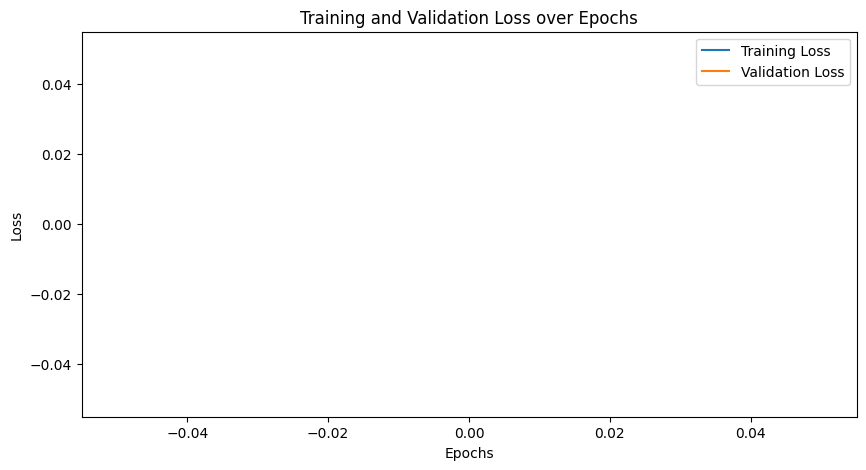

Finished Training


In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

print('Finished Training')

## Evaluación y Predicción en el conjunto de Test

1. **Evaluación de las predicciones**:
Se pone el modelo en modo `eval()` y se itera sobre el conjunto de validación para obtener las predicciones y se calcula el F1 usando el mejor umbral.

2. **Preparación del conjunto de Test**:
Se crea la clase `BirdSongTestDataset` que lee de `test.csv`, y se crea un DataLoader para el conjunto de Test.

3. **Predicciones en el conjunto de Test**:
Se itera sobre el conjunto de test y se obtienen las predicciones del modelo para cada archivo de audio. Se binarizan usando el mejor umbral y se almacenan en un diccionario con el nombre del archivo como clave.
Las predicciones se convierten en un DataFrame de Pandas y se preparan los datos en el formato esperado, y por último se guarda el DataFrame en un archivo CSV.

In [16]:
best_threshold_val = 0.1
print(f"Best threshold: {best_threshold_val}")

Best threshold: 0.1


In [17]:
model.eval()
audio_preds = defaultdict(list)
audio_labels = defaultdict(list)

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(valid_loader):
        # Process through feature extractor and to device
        inputs = feature_extractor(inputs.squeeze(1).numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

        # Ensure the input shape is compatible with the model
        if inputs.input_values.shape[-1] < 16:
            padding = 16 - inputs.input_values.shape[-1]
            inputs.input_values = F.pad(inputs.input_values, (0, padding), 'constant', 0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(**inputs)

        # Extract logits and apply sigmoid
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)

        # Compare with threshold
        preds = (probabilities > best_threshold_val).float()

        # Fetch the filename for each segment
        for i, (input_, label, pred) in enumerate(zip(inputs, labels, preds)):
            # Compute the correct index in the dataset
            dataset_index = batch_idx * valid_loader.batch_size + i
            filename = valid_dataset.get_filename(dataset_index)
            audio_preds[filename].append(pred.cpu().numpy())
            # The label should be the same for all segments of the same audio, so we append it only once
            if filename not in audio_labels:
                audio_labels[filename] = label.cpu().numpy()

# Aggregating the segment-level predictions for each audio to generate a single prediction for the whole audio
for filename in audio_preds:
    # Here, we take the max prediction for each class across all segments as the audio-level prediction
    audio_preds[filename] = np.maximum.reduce(audio_preds[filename])

all_labels = list(audio_labels.values())
all_preds = list(audio_preds.values())

f1_macro = f1_score(all_labels, all_preds, average='samples', zero_division=1)
print(f"F1 Score (Samples): {f1_macro}")


F1 Score (Samples): 0.06806282722513089


In [39]:
class BirdSongTestDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        segments = []

        unique_filenames = df['filename'].unique()
        for unique_filename in unique_filenames:
            audio_path = os.path.join(audio_dir, unique_filename)
            waveform, sample_rate = torchaudio.load(audio_path)
            total_segments = int(math.ceil(waveform.shape[1] / sample_rate))

            for idx in range(total_segments):
                start_time, end_time = idx, idx + 1
                segments.append({
                    'filename': unique_filename,
                    'segment_idx': idx,
                    'start': start_time,
                    'end': end_time,
                })

        self.segments = pd.DataFrame(segments)
        self.audio_dir = audio_dir
        self.transform = transform


    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        row = self.segments.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        waveform, sample_rate = torchaudio.load(audio_path)

        # Ensure waveform is mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to 16000 Hz if necessary
        if sample_rate != 16000:
            resampler = Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Extract 1-second segment
        start_sample = int(row['start'] * 16000)
        end_sample = int(row['end'] * 16000)
        waveform = waveform[:, start_sample:end_sample]

        # Padding if needed
        if waveform.shape[1] < 16000:
            num_padding = 16000 - waveform.shape[1]
            waveform = torch.cat([waveform, torch.zeros(1, num_padding)], dim=1)

        # If the waveform is a tensor, this squeeze operation will work
        return waveform, row['filename'], row['segment_idx']

In [40]:
test_csv = pd.read_csv(f'{base_path}data/test.csv')

def collate_fn(batch):
    segments = [item[0] for item in batch]  # Ensure item[0] is a tensor
    filenames = [item[1] for item in batch]
    segment_indices = [item[2] for item in batch]

    segments_tensor = torch.stack(segments, dim=0)  # Stack the segment tensors

    return segments_tensor, filenames, segment_indices


test_dataset = BirdSongTestDataset(test_csv, f'{base_path}data/test/', transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [41]:
# for batch in test_loader:
#     print(type(batch))
#     break

In [42]:
# if DEBUG:
#   (sample, intermediates), filename, label = test_dataset[25]
#   print(filename)
#   print(sample.shape)
#   visualize_intermediates(intermediates)

In [43]:
# Make predictions on test set
model.eval()
predictions = defaultdict(lambda: np.zeros(len(class_names), dtype=bool))

with torch.no_grad():
    for inputs, filenames, segment_indices in test_loader:
        # Process through feature extractor and to device
        inputs = feature_extractor(inputs.squeeze(1).numpy(), sampling_rate=16000, return_tensors="pt", padding=True)


        # Ensure the input shape is compatible with the model
        if inputs.input_values.shape[-1] < 16:
            padding = 16 - inputs.input_values.shape[-1]
            inputs.input_values = F.pad(inputs.input_values, (0, padding), 'constant', 0)

        inputs = inputs.to(device)

        # Forward pass through the model
        outputs = model(**inputs)

        # Extract logits and apply sigmoid
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)

        # Compare with threshold
        preds = (probabilities > best_threshold_val).float().cpu().numpy().astype(bool)

        # Aggregate predictions for each audio file
        for fname, pred in zip(filenames, preds):
            predictions[fname] = np.logical_or(predictions[fname], pred)

# Convert boolean values to integer (0 or 1)
for key in predictions:
    predictions[key] = predictions[key].astype(int)

submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)